## Here is an example of our process for automatic selection of dimensionality

Based on the approach in: 
  T.  P.  Minka, Automatic choice of dimensionality for PCA, Tech. Rep. (2000).
https://vismod.media.mit.edu/pub/tech-reports/TR-514.pdf

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from gwpy.timeseries import TimeSeries

from corner import corner
from tqdm import tqdm
from pycbc.filter import get_cutoff_indices

from scipy.signal import tukey
from scipy.stats.distributions import norm
from scipy.special import loggamma

In [5]:
glitches = np.load("./data/H1O3a_Tomtes_10-128.npy")

In [6]:
srate = 2048
times = np.arange(glitches.shape[1]) / srate
siglen = 1

timeseries_data = []

white_timeseries_data = np.empty((glitches.shape[0], int(srate * siglen)))
white_freqseries_data = np.empty((glitches.shape[0], int((srate * siglen)/2 + 1)), dtype='complex')

for i, raw_ts in enumerate(glitches):
    ts = TimeSeries(raw_ts, times=times)
    white_timeseries_data[i] = ts.value
    white_freqseries_data[i] = ts.fft().value
    timeseries_data.append(ts)

In [7]:
test_frac = 0.1
test_sel = np.random.choice([True, False], size=glitches.shape[0], p=[test_frac, 1-test_frac])

test_size = np.count_nonzero(test_sel)
train_size = glitches.shape[0] - test_size

white_timeseries_data_test = white_timeseries_data[test_sel]
white_timeseries_data_train = white_timeseries_data[~test_sel]
white_freqseries_data_test = white_freqseries_data[test_sel]
white_freqseries_data_train = white_freqseries_data[~test_sel]

In [8]:
flow = 20.
fhigh = srate/2
kmin, kmax = get_cutoff_indices(flow, fhigh, 1/siglen, int(srate * siglen))

## Freq Domain PPCA TF 

In [9]:
sigcentidx = 1024
idx_win = 1024
sig_start_idx = sigcentidx-idx_win//2
sig_end_idx = sigcentidx+idx_win//2
window = tukey(idx_win, .2)

X_fd_train = np.fft.rfft(window*white_timeseries_data_train[:, sig_start_idx:sig_end_idx])
X_fd_test = np.fft.rfft(window*white_timeseries_data_test[:, sig_start_idx:sig_end_idx])
X_train = np.concatenate([X_fd_train.real, X_fd_train.imag], axis=1).T
X_test = np.concatenate([X_fd_test.real, X_fd_test.imag], axis=1).T

mu = X_train.mean(axis=1)
#X_train -= mu[:, np.newaxis]
noise_std = 1/2 * 2/(idx_win/srate)

From [here](https://www.apps.stat.vt.edu/leman/VTCourses/PPCA.pdf).

$$
x | z \sim \mathcal{N}(\mathbf{W}z + \mu, \sigma^2\mathbf{I})
$$

$$
x \sim \mathcal{N}(\mu, \mathbf{C})
$$

$$
\mathbf{C} = \mathbf{W}\mathbf{W}^\mathrm{T} + \sigma^2\mathbf{I}
$$

$$
\mathbf{S} = \frac{1}{N} \Sigma_{n=1}^N (x_n - \mu)(x_n - \mu)^\mathrm{T}
$$

$$
z | x \sim \mathcal{N}(\mathbf{M}^{-1}\mathbf{W}^\mathrm{T}(x - \mu), \sigma^2\mathbf{M}^{-1})
$$

$$
\mathbf{M} = \mathbf{W}^\mathrm{T}\mathbf{W} + \sigma^2\mathbf{I}
$$

Note that $\mathbf{M}$ is $q\times q$ and $\mathbf{C}$ is $d\times d$.

$$
\mathbf{W}_\mathrm{ML} = \mathbf{U}_q (\Lambda_q - \sigma^2 \mathbf{I})^{1/2} \mathbf{R},
$$

where $\mathbf{U}_q$ is $d\times q$ with $q$ column-vectors that are the principle eigenvectors of $\mathbf{S}$ with corresponding eigenvalues $\lambda_1, \dots, \lambda_q$ in the $q\times q$ diagonal matrix $\Lambda_q$.  $\mathbf{R}$ is an arbitrary rotation matrix that we'll likely take as $\mathbf{I}$.

Finally, for $\mathbf{W} = \mathbf{W}_\mathrm{ML}$, the ML estimator for $\sigma$ is

$$
\sigma^2_\mathrm{ML} = \frac{1}{d - q} \Sigma^{d}_{j = q + 1} \lambda_j,
$$

i.e., the variance 'lost' in the projection, averaged over the lost dimensions.

In [10]:
S = np.cov(X_train)
λ, U = np.linalg.eigh(S)
λ = λ[::-1]
U = U[:, ::-1]
Λ = np.diagflat(λ)

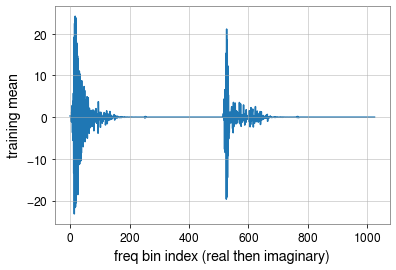

In [11]:
plt.plot(mu)
plt.xlabel('freq bin index (real then imaginary)')
plt.ylabel('training mean');

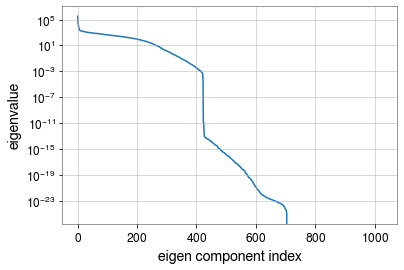

In [12]:
plt.semilogy(λ)
plt.ylabel('eigenvalue')
plt.xlabel('eigen component index');

# Model Selection

Following [this work](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.43.7064), we can assume a uniform prior on the mean

$p(\mathbf{\mu}) = \mathrm{constant}$

and a diffuse conjugate prior on the eigenvector/value-relate matrices to be able to calculate marginal likelihoods (i.e., evidences) as a function of the latent space dimensionality $k$.

## Laplace Approximation

After a lot of work that I can't follow, the Laplace approximation to the marginal likelihood conditioned on a choice of $q$ PPCA components ($k$ in this paper) reduces to Eq. 76:

$$
p(\mathbf{x} \mid q) \approx p(\mathbf{U})\left(\prod_{j=1}^{q} \lambda_{j}\right)^{-N / 2} \hat{\sigma}^{-N(d-q) / 2}(2 \pi)^{(m+q) / 2}\left|\mathbf{A}_{Z}\right|^{-1 / 2} N^{-q / 2}
$$

where $\hat{\sigma}$ ($\hat{v}$ in this paper) is the max-likelihood estimate of the noise given by the average of the remaining eigenvalues
$$
\hat{\sigma}=\frac{\sum_{j=q+1}^{d} \lambda_{j}}{d-q},
$$

$m$ is the dimension of some manifold, $m=dq-q(q+1)/2$.  The marginalized conjugate prior for $\mathbf{U}$ is given by Eq. 50:

$$
p(\mathbf{U})=2^{-q} \prod_{i=1}^{q} \Gamma((d-i+1) / 2) \pi^{-(d-i+1) / 2},
$$

and finally the determinant of the Hessian, $\left|\mathbf{A}_{Z}\right|$, is given by Eq. 71:
$$
\left|\mathbf{A}_{Z}\right|=\prod_{i=1}^{q} \prod_{j=i+1}^{d}\left(\hat{\lambda}_{j}^{-1}-\hat{\lambda}_{i}^{-1}\right)\left(\lambda_{i}-\lambda_{j}\right) N.
$$

In [13]:
# N: # training examples
# d: # of features (i.e., 2x the # of freq bins)
# q: latent space dimensionality

d, N = X_train.shape
qs = np.arange(15)

In [14]:
def log_p_U(q):
    '''(Log) marginalized conjugate prior for U (eq. 50)'''
    return -q * np.log(2) + np.sum(loggamma((d - np.arange(q) + 1)/2) - (d - np.arange(q) + 1)*np.log(np.pi)/2)

In [15]:
def log_det_A_Z(q, λ=λ):
    '''(Log) determinant of the Hessian in eq. 71'''
    log_det = 0
    
    λ = np.abs(λ) + 1e-25 # ensure stability
    for i in np.arange(q):
        for j in np.arange(i+1, d):
            log_det += np.log(1/λ[j] - 1/λ[i]) + np.log(λ[i] - λ[j]) + np.log(N)
    return log_det

In [16]:
def marg_log_l_laplace(q):
    '''Laplace approximation of the (log) marginal likelihood for a `q`-component PPCA model (eq. 76)'''
    σ_ML = np.mean(λ[q:])
    m = d*q - q*(q+1)/2

    logl = log_p_U(q)
    logl -= N/2 * np.sum(np.log(λ[:q]))
    logl -= N*(d-q)/2 * np.log(σ_ML)
    logl += (m + q)/2 * np.log(2*np.pi)
    logl -= 1/2 * log_det_A_Z(q)
    logl -= q/2 * np.log(N)
    return logl

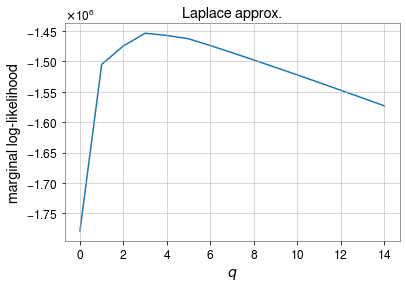

In [17]:
plt.plot(qs, [marg_log_l_laplace(q) for q in qs])
plt.xlabel('$q$')
plt.ylabel('marginal log-likelihood')
plt.title('Laplace approx.');

## BIC
If we're only concerned with a BIC-type estimate of this quantity then we can drop everything that doesn't scale with $N$, which leaves Eq. 78
$$
p(\mathbf{x} \mid k) \approx\left(\prod_{j=1}^{k} \lambda_{j}\right)^{-N / 2} \hat{\sigma}^{-N(d-k) / 2} N^{-(m+k) / 2}
$$

In [18]:
def marg_log_l_BIC(q):
    σ_ML = np.mean(λ[q:])
    m = d*q - q*(q+1)/2

    return -N/2*np.sum(np.log(λ[:q])) - N*(d-q)/2*np.log(σ_ML) - (m + q)/2*np.log(N)

Text(0.5, 1.0, 'H1 O3a Tomtes')

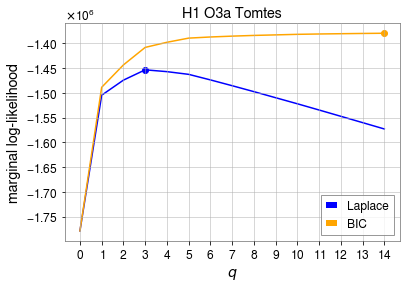

In [19]:
title = 'H1 O3a Tomtes'
plt.plot(qs, [marg_log_l_laplace(q) for q in qs], label='Laplace', color='blue')
plt.plot(qs, [marg_log_l_BIC(q) for q in qs], label='BIC', color='orange')
plt.scatter(np.argmax([marg_log_l_laplace(q) for q in qs]),\
            marg_log_l_laplace(np.argmax([marg_log_l_laplace(q) for q in qs])),\
            marker='o', color='blue')
plt.scatter(np.argmax([marg_log_l_BIC(q) for q in qs]),\
            marg_log_l_BIC(np.argmax([marg_log_l_BIC(q) for q in qs])),\
            marker='o', color='orange')
plt.xlabel('$q$')
plt.ylabel('marginal log-likelihood')
plt.xticks(qs)
plt.legend();
plt.title(title)

In [20]:
np.argmax([marg_log_l_laplace(q) for q in qs])

3

In [21]:
np.argmax([marg_log_l_BIC(q) for q in qs])

14